In [46]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import util as ut

from scipy.fft import rfft, ifft, fftshift, fftfreq
import seaborn as sn
import scipy as sc
from scipy import ndimage
from scipy.signal import hilbert 

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels
from Inner_Speech_Dataset.Python_Processing.Data_processing import Average_in_frec

In [47]:


sampling_rate = 256
nr_of_datasets=1
specificSubject = 2
data, labels = dl.load_multiple_datasets(nr_of_datasets=nr_of_datasets, 
sampling_rate=sampling_rate, t_min=2, t_max=3, 
twoDLabels=False, specificSubject = specificSubject)
#Names of EEG channels 
ch_names = ut.get_channelNames()


data_p =  ut.get_power_array(data[:,:128,:], sampling_rate, trialSplit=1).squeeze()
print("Power band data shape: {}".format(data_p.shape))

#Creating freqBandBuckets
nr_of_buckets = 15
buckets = ut.getFreqBuckets(data, nr_of_buckets=nr_of_buckets)


#Getting Freq Data 
data_f = ut.data_into_freq_buckets(data[:,:128,:], nr_of_buckets, buckets)
print("Freq band bucket separated data shape: {}".format(data_f.shape))



Data shape: [trials x channels x samples]
(600, 128, 256)
Labels shape
(600, 4)
Final data shape
(120, 128, 256)
Final labels shape
(120,)
Up is 0.0 and Down is 1.0
Power band data shape: (120, 128, 2)
buckets
[[  0   1]
 [  1   4]
 [  4   8]
 [  8  12]
 [ 12  18]
 [ 18  25]
 [ 25  33]
 [ 33  42]
 [ 42  53]
 [ 53  67]
 [ 66  81]
 [ 80  97]
 [ 88 106]
 [ 62  73]
 [  4   5]]
Freq band bucket separated data shape: (120, 128, 15)


FFT data shape: (120, 128, 128)
(120, 128, 128)
Welchdata data shape: (120, 128, 128)
(120, 128, 128)
Hilbert real data shape: (120, 128, 256)
(120, 128, 128)
(120, 128, 128)
(120, 128, 128)


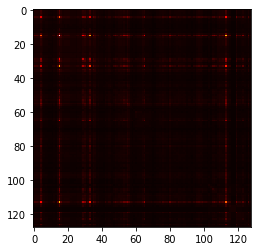

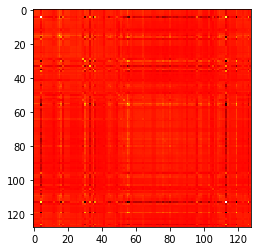

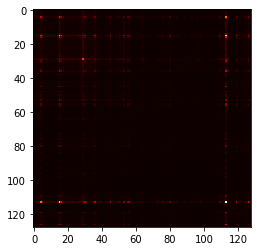

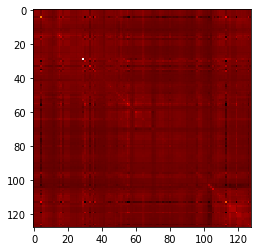

In [48]:


#Make FFT data
fftdata = ut.fftData(data)
print("FFT data shape: {}".format(fftdata.shape))

#Make covariance of FFT data
dataFFTCV = np.array(ut.fftCovariance(fftdata))
print(dataFFTCV.shape)

#Make Welch data
welchdata = ut.welchData(data, fs=256, nperseg=256)
print("Welchdata data shape: {}".format(welchdata.shape))

#Make covariance of welch data
dataWCV = np.array(ut.fftCovariance(welchdata))
print(dataWCV.shape)

#Hilbert data
dataH = hilbert(data, axis=2, N=256)
dataHR = dataH.real
dataHI = dataH.imag
print("Hilbert real data shape: {}".format(dataHR.shape))

#Make covariance of Hilber data
dataHRCV= np.array(ut.fftCovariance(dataHR))
print(dataHRCV.shape)
dataHICV= np.array(ut.fftCovariance(dataHI))
print(dataHICV.shape)

#Make covariance of non fft data
datagauss = ndimage.gaussian_filter1d(data, 5, axis=2)
dataCV = np.array(ut.fftCovariance(datagauss))
print(dataCV.shape)


#Note try PSD 


#Plot heatmaps 
def plotHeatMaps(plotData):
    plt.figure()
    plt.imshow(plotData, cmap="hot", interpolation="nearest")
    plt.show()


plotHeatMaps(dataFFTCV[2])
plotHeatMaps(dataCV[2])
plotHeatMaps(dataWCV[2])
plotHeatMaps(dataHRCV[2])



In [49]:


dataT = np.concatenate([dataWCV, dataHRCV, dataHICV], axis =1 ) #, data
#dataT = dataHRCV
#dataT = dataCV2
#dataT = dataWCV

print("Data used for training and testing shape: {}".format(dataT.shape))
print("Label data used for training and testing shape: {}".format(labels.shape))

#Normalize data
dataT = keras.utils.normalize(dataT, axis=1, order=2)



Data used for training and testing shape: (120, 384, 128)
Label data used for training and testing shape: (120, 2)


In [50]:
#Splitting into training and test data

data_train, data_test, labels_train, labels_test = ut.splitData(dataT, labels, 0.8)



(96, 2)
(96, 384, 128)
(24, 384, 128)


In [51]:
#!pip3 install sklearn -q
from tabnanny import verbose
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

def svmPipeline(data_train, data_test, labels_train,
    labels_test, kernel="linear", degree=3, gamma="auto", C = 1
    , coefs = np.zeros([1, data_train.shape[1] * data_train.shape[2]])): 
    
    anova_filter = SelectKBest(f_classif, k=10)
    clf = make_pipeline( StandardScaler() ,  SVC( #anova_filter/#,
        gamma=gamma, kernel=kernel, degree=degree, verbose=False, C=C))

    clf.fit(np.reshape(data_train, [data_train.shape[0], -1]), labels_train)
    predictions = clf.predict(np.reshape(data_test, [data_test.shape[0], -1]))
    
    
    if kernel == "linear":
        print(classification_report(labels_test, predictions))
        coefs = coefs + clf[:-1].inverse_transform(clf[-1].coef_)
    #print(clf[:-1].inverse_transform(clf[-1].coef_).shape)

    correct = np.zeros(labels_test.shape)
    correctamount=0
    for nr, pred in enumerate(predictions,0):
        if pred == labels_test[nr]:
            correct[nr] = 1
            correctamount +=1


    return correctamount/labels_test.shape[0], coefs

#testing using different kernels, C and degrees. 
coefs = np.zeros([1, data_train.shape[1] *data_train.shape[2]]) #
for kernel in ["linear", "rbf", "sigmoid"]:
    if kernel == "linear":
        for C in np.linspace(0.2,0.8,3):
        
            for degree in range(2,3):
                res, coefs = svmPipeline(data_train, data_test, labels_train, 
                labels_test, degree=degree, kernel = kernel, C = C, coefs=coefs)
                print("Result for degree {}, kernel {}, C = {}: {}".format(degree, kernel, (C*100//10)/10,  res))
    # else:
    #     for C in np.linspace(0.5,3,4):
    #         for gamma in ["auto", "scale"]:

    #             res = svmPipeline(data_train, data_test, labels_train, 
    #             labels_test, degree=degree, kernel = kernel, gamma=gamma, C = C)
    #             print("Result for gamma {}, kernel {}, C = {}: {}".format(gamma, kernel, (C*100//10)/10, res[0]))

coefs = np.reshape(coefs, [128,-1])

In [52]:
#!pip3 install sklearn -q
from tabnanny import verbose
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

def svmPipeline(data_train, data_test, labels_train,
    labels_test, kernel="linear", degree=3, gamma="auto", C = 1
    , coefs = np.zeros([1, data_train.shape[1] * data_train.shape[2]])): 
    
    anova_filter = SelectKBest(f_classif, k=10)
    clf = make_pipeline( StandardScaler() ,  SVC( #anova_filter/#,
        gamma=gamma, kernel=kernel, degree=degree, verbose=False, C=C))

    clf.fit(np.reshape(data_train, [data_train.shape[0], -1]), labels_train)
    predictions = clf.predict(np.reshape(data_test, [data_test.shape[0], -1]))
    
    
    if kernel == "linear":
        print(classification_report(labels_test, predictions))
        coefs = coefs + clf[:-1].inverse_transform(clf[-1].coef_)
    #print(clf[:-1].inverse_transform(clf[-1].coef_).shape)

    correct = np.zeros(labels_test.shape)
    correctamount=0
    for nr, pred in enumerate(predictions,0):
        if pred == labels_test[nr]:
            correct[nr] = 1
            correctamount +=1


    return correctamount/labels_test.shape[0], coefs

#testing using different kernels, C and degrees. 
coefs = np.zeros([1, data_train.shape[1] *data_train.shape[2]]) #
for kernel in ["linear", "rbf", "sigmoid"]:
    if kernel == "linear":
        for C in np.linspace(0.2,0.8,3):
        
            for degree in range(2,3):
                res, coefs = svmPipeline(data_train, data_test, labels_train, 
                labels_test, degree=degree, kernel = kernel, C = C, coefs=coefs)
                print("Result for degree {}, kernel {}, C = {}: {}".format(degree, kernel, (C*100//10)/10,  res))
    # else:
    #     for C in np.linspace(0.5,3,4):
    #         for gamma in ["auto", "scale"]:

    #             res = svmPipeline(data_train, data_test, labels_train, 
    #             labels_test, degree=degree, kernel = kernel, gamma=gamma, C = C)
    #             print("Result for gamma {}, kernel {}, C = {}: {}".format(gamma, kernel, (C*100//10)/10, res[0]))

coefs = np.reshape(coefs, [128,-1])

Works for 1 subject data, 64 percent acc?
